# Closed XXZ Chain Bethe Ansatz Eigenstates on a Quantum Computer
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$

In [75]:
from qiskit import *
from math import pi, acos, asin, atan, sqrt, comb, cos, sin, copysign
import numpy as np

from qiskit.circuit.library.standard_gates import RYGate,XGate, PhaseGate, ZGate
from qiskit.circuit import Parameter

np.set_printoptions(suppress=True)

from qiskit.quantum_info import Statevector

from qiskit.visualization import plot_histogram

We also initialize some nice functions that are useful:

In [2]:
def test_circ(circ, qReg=None, cReg=None, shots= 1000):
    
    ### MEASURES THE CIRCUIT IN QASM SIMULATOR ###
    
    from qiskit import Aer

    simulator = Aer.get_backend('qasm_simulator')

    # We've set the number of shots (repeats) of the circuit
    # to be 1024, which is the default value
    #circ.measure(qReg,cReg)
    job_sim = execute(circ, backend=simulator, shots=shots)

    # Grab the results from the job
    result_sim = job_sim.result()

    counts_sim = result_sim.get_counts(circ)
    #print(counts_sim)

    #remove_M(circ)
    print(counts_sim)
    from qiskit.visualization import plot_histogram
    # Plot a histogram of the results
    return plot_histogram(counts_sim)

def remove_M(circ):
    
    ### REMOVES ALL MEASUREMENT GATES ###
    
    i = 0
    while i < (len(circ.data)):
        if i>=len(circ.data):
            break
        if "Measure" in str(circ.data[i][0]):
            circ.data.pop(i)
            i = i-1
        i = i+1       

def statevector(circ, L, M, work = False):
    from qiskit.quantum_info import Statevector
    if work:
        w = 1
    else:
        w = 0
    remove_M(circ)
    sv = Statevector.from_label('0'*(L+M**2+M+w))
    state = sv.evolve(circ)
    return state.data[0:2**L]

In [3]:

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

## Bethe Eigenstate circuit

## Step 1: Generating the dicke states $\ket{D_{L,M}}$, by Bärtschi and Eidenbenz (arXiv:1904.07358, 2019)

#### Ch 2.2.1) Explicit Construction of  the $ U_{n k}$ on n qubits to obtain the Dicke state $\ket{D_{L,M}}$

In [4]:
def dicke_init(circ, L, M, q):

    last = L-1
    first = 0

    # initializing the |1> qubits:

    for i in range(first, M):
        circ.x(q[last-i])

def SCS2(circ, last, i, q):
    # (i) gate
    circ.cx(q[last-1-i], q[last-i])
    circ.cry(2*np.arccos(np.sqrt(1/(L-i))),q[last-i], q[last-1-i])
    circ.cx(q[last-1-i], q[last-i])

def SCS3(circ, last, i, j, q):

    circ.cx(q[(last-1-i)-1-j], q[last-i])
    ## Constructing the double-controlled Ry gate
    a = 2*np.arccos(np.sqrt((j+2)/(L-i))) # Parameter('a') # You can replace a with your choice of angle here
    CCRY=RYGate(a).control(2)
    circ.append(CCRY,[last-i, last-i-1-j,(last-1-i)-1-j])
    circ.cx(q[(last-1-i)-1-j], q[last-i]) 
    
    
def dicke_prepare(circ, L, M, q):
    
    dicke_init(circ, L, M, q)
    
    last = L-1
    first = 0
    for i in range(first, last):
        SCS2(circ, last, i, q)
        if L-i == M:
            # decrease M by 1, if SCS_{M,M} would be reached next
            M = M - 1
        #(ii) gate(s)
        for j in range(0, M-1):
            SCS3(circ, last, i, j, q)

## Step 2: Constructing the permutation ancillas $\left(\frac{1}{\sqrt{M !}} \sum_{P} A_{P} \otimes_{j=M}^{1}|P j\rangle_{p}\right)$

We first need the ASWAP gate.

In [12]:
def angle(k):
    ret = asin(1/sqrt(k+2))
    return ret#+(-1)**(copysign(1, ret)+1)*pi/2

def ASWAP(circ, k, target1, target2, q):
    theta = angle(k)
    circ.cx(q[target2],q[target1])
    circ.rz(-pi,q[target2])
    circ.ry(-angle(k),q[target2])
    circ.cx(q[target1],q[target2])
    circ.ry(angle(k),q[target2])
    circ.rz(pi,q[target2])
    circ.cx(q[target2],q[target1])
    
def index(subregister, qubit):
    return subregister*M+qubit

def theta(ki,kj):
    d = (ki-kj)/2
    s = (ki+kj)/2
    return 2*atan((delta*sin(d)/(delta*cos(d)-cos(s))))
# delta = -0.5
# bethek = [1.14676529, 3.56562369]

In [13]:
def permutations(circ, M, q, phase=True,bethek = [], params=False):
    if params:
        a=[0,0,0,0,0,0,0]
    k = 0
    # NOT gate on the zeroeth qubit to obtain the 0 subregister.
    circ.x(q[k])
    #print(bethek)
    ### ITERATION k=0 ###
    for k in range(0, M-1):
        # NOT gate on the k+1 qubit of the k+1 subregister
        circ.x(q[index(k+1,k+1)])
        for i in range(0, k+1):
            # Construct ASWAP gates
            ASWAP(circ, k-i, index(k-i,k+1), index(k+1-i,k+1), q)
            # Iterate from: control at subregister k, qubit k+1 ---> control = q[index(k,k+1)]
            #                                             targets: (q[index(k,l)], q[index(k+1,l)]) with l =0 to l = k-1
            for l in range(0, k+1):
                circ.cswap(q[index(k-i,k+1)], q[index(k-i,l)], q[index(k+1-i,l)])
            if phase:
                for l in range(0, k+1):
                    #print(str(k+1) + ", "+ str(l))
                    if params:
                        a[l] = Parameter('theta('+str(k+1)+','+str(l)+')   '+str(i))
                        circ.cp(a[l],q[index(k+1-i,l)],q[index(k-i,k+1)])
                    circ.cp(theta(bethek[k+1],bethek[l])+pi,q[index(k+1-i,l)],q[index(k-i,k+1)])

### Step 3: Faucets

In [8]:
def faucets(circ, L, M, qFaucet, qPerm, qSys, qWork=None, bethek = []):
    first = 0
    last = L-1

    dickeFirst = first
    dickeLast = last

    first = 0
    last = first+M

    #initialize the faucets to |1>

    for i in range(first, last):
        circ.x(qFaucet[i])

    circ.barrier()

    edge = L-M
    
    shift = L+M**2
    
    for i in range(dickeFirst, dickeLast+1):
        j = last-1
        while j >= first:
            if (j <= i and i<=edge) or (j>= (i-edge) and (dickeLast+1-i)<=edge):
                if j == last - 1:
                    CCCX=XGate().control(2)
                    circ.x(qFaucet[((j-1)%M)]) 
                    circ.append(CCCX, [i, ((j-1)%M)+shift,(j%M)+shift])
                    circ.x(qFaucet[((j-1)%M)])
                elif j == first:
                    CCCX=XGate().control(2)
                    circ.append(CCCX, [i, ((j+1)%M)+shift,(j%M)+shift])
                else:
                    circ.x(qFaucet[((j-1)%M)]) 
                    if qWork is not None:
                        circ.ccx(qFaucet[(j-1)%M],qFaucet[(j+1)%M], qWork[0])
                        circ.ccx(qSys[i], qWork[0], qFaucet[j%M])
                        circ.ccx(qFaucet[(j-1)%M],qFaucet[(j+1)%M], qWork[0])
                    else:
                        CCCX=XGate().control(3)
                        circ.append(CCCX, [i, ((j-1)%M)+shift, ((j+1)%M)+shift,(j%M)+shift])
                    circ.x(qFaucet[((j-1)%M)])
            j = j -1
        circ.barrier()
        for j in range(first, last):
            for l in range(index(j,0),index(j,M)):
                circ.cp(bethek[l%M], qFaucet[j], qPerm[l])

### Step 4: Reversing the Permutations

In [9]:
def rev_permutations(circ, M, q):
    for k in reversed(range(0, M-1)):
        for i in reversed(range(0, k+1)):
            # Iterate from: control at subregister k, qubit k+1 ---> control = q[index(k,k+1)]
            #                          targets: (q[index(k,l)], q[index(k+1,l)]) with l =0 to l = k-1
            for l in reversed(range(0, k+1)):
                circ.cswap(q[index(k-i,k+1)], q[index(k-i,l)], q[index(k+1-i,l)])
            # Construct ASWAP gates
            ASWAP(circ, k-i, index(k-i,k+1), index(k+1-i,k+1), q)
        # NOT gate on the k+1 qubit of the k+1 subregister
        circ.x(q[index(k+1,k+1)])
    #NOT gate on the 0 qubit of the 0 subregister
    circ.x(q[k])

## Total Bethe Circuit. Step 3 and 4: The faucet method and reversing the permutations included.

In [102]:
def bethe_moments(L,M):
    betheMoments = {
        "4,2" : [2*pi/3, 4*pi/3],
        "6,3" : [pi, 1.7227684498700901, -1.7227684498700901],#-2*pi+4.56042],
        "5,2" : [pi/2, 3*pi/2]
    }

    bethek = betheMoments[str(L)+","+str(M)]

    if len(bethek) != max(M, L-M):
        print("length of momentum array is incorrect")
    return bethek

def check_state(circ, L, M, work=True):
    correct_state = {
    "4,2" : correct42,
    "6,3" : correct63,
    }
    realState = correct_state[str(L)+","+str(M)]
    return statevector(circ, L, M, work)-realState

def correlation(circ, pos, q, qPerm):#, qWork, cWork):
    circ.barrier()
    for i in range(qPerm.size):
        circ.x(qPerm[i])
    for i in range(qPerm.size):
        if i in pos:
            multiZ = ZGate().control(qPerm.size)
            circ.append(multiZ, [i+q.size for i in range(qPerm.size)]+[i])
    for i in range(qPerm.size):
        circ.x(qPerm[i])

In [19]:
correct63 = [ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.01625186-0.01893038j,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        , -0.05367626+0.06252281j,
        0.        +0.j        ,  0.05367626-0.06252281j,
       -0.01625186+0.01893038j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.05367626-0.06252281j,
        0.        +0.j        , -0.12360439+0.14397599j,
        0.05367626-0.06252281j,  0.        +0.j        ,
        0.        +0.j        ,  0.05367626-0.06252281j,
       -0.05367626+0.06252281j,  0.        +0.j        ,
        0.01625186-0.01893038j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        , -0.01625186+0.01893038j,
        0.        +0.j        ,  0.05367626-0.06252281j,
       -0.05367626+0.06252281j,  0.        +0.j        ,
        0.        +0.j        , -0.05367626+0.06252281j,
        0.12360439-0.14397599j,  0.        +0.j        ,
       -0.05367626+0.06252281j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.01625186-0.01893038j,
       -0.05367626+0.06252281j,  0.        +0.j        ,
        0.05367626-0.06252281j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
       -0.01625186+0.01893038j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ]
correct42 = [ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.10206207-0.1767767j ,
        0.        +0.j        , -0.20412415+0.35355339j,
        0.10206207-0.1767767j ,  0.        +0.j        ,
        0.        +0.j        ,  0.10206207-0.1767767j ,
       -0.20412415+0.35355339j,  0.        +0.j        ,
        0.10206207-0.1767767j ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ]
hide_toggle()

In [22]:
###       Some parameters  ###
# anisotropy parameter
delta = 1

# chain length
L = 6
# how many down spins you want
M = 3

# create L quantum registers, one for each spin on the chain 
                                #plus M^2 for the permutation ancillas
                                #plus M faucet ancillas 
                                #plus 1 work qubit
qSys = QuantumRegister(L, "dicke")
qPerm = QuantumRegister(M**2, "perm")
qFaucet = QuantumRegister(M, "faucet")
qWork = QuantumRegister(1, "work")

# create corresponding classical registers (for measurement )
cSys = ClassicalRegister(L)
cPerm = ClassicalRegister(M**2)
cFaucet = ClassicalRegister(M)
cWork = ClassicalRegister(1)

bethe = QuantumCircuit(qSys, qPerm, qFaucet,qWork, cSys, cPerm, cFaucet,cWork)
hide_toggle()

In [23]:
bethek = bethe_moments(L,M)

dicke_prepare(bethe, L, M, qSys)

permutations(bethe, M, qPerm, True, bethek)

faucets(bethe, L, M, qFaucet, qPerm, qSys, qWork, bethek)

rev_permutations(bethe, M, qPerm)

hide_toggle()

[3.141592653589793, 1.7227684498700901, -1.7227684498700901]


In [24]:
check_state(bethe, L, M)

#hide_toggle()

array([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j,
        0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.+0.j, -0.-0.j,
        0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.-0.j, -0.-0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j])

In [103]:
def generate_bethe(L=4, M=2, work=True, show_state=True, anisotropy=1):
    # create L quantum registers, one for each spin on the chain 
                                #plus M^2 for the permutation ancillas
                                #plus M faucet ancillas 
                                #plus 1 work qubit
    qSys = QuantumRegister(L, "dicke")
    qPerm = QuantumRegister(M**2, "perm")
    qFaucet = QuantumRegister(M, "faucet")
    qWork = QuantumRegister(1, "work")

    # create corresponding classical registers (for measurement )
#     cSys = ClassicalRegister(L)
#     cPerm = ClassicalRegister(M**2)
#     cFaucet = ClassicalRegister(M)
#     cWork = ClassicalRegister(1)

    bethe = QuantumCircuit(qSys, qPerm, qFaucet,qWork)#, cSys, cPerm, cFaucet,cWork)
    bethem = bethe_moments(L,M)

    dicke_prepare(bethe, L, M, qSys)

    permutations(bethe, M, qPerm, True, bethem)

    faucets(bethe, L, M, qFaucet, qPerm, qSys, qWork if work else None, bethem)

    rev_permutations(bethe, M, qPerm)
    
    correlation(bethe, [1,3], qSys, qPerm)
    
    if show_state:
        print(statevector(bethe, L, M, work))
    
    return bethe

In [104]:
L = 6
M = 3

myBethe = generate_bethe(L, M, work=True, show_state=False)

[3.141592653589793, 1.7227684498700901, -1.7227684498700901]


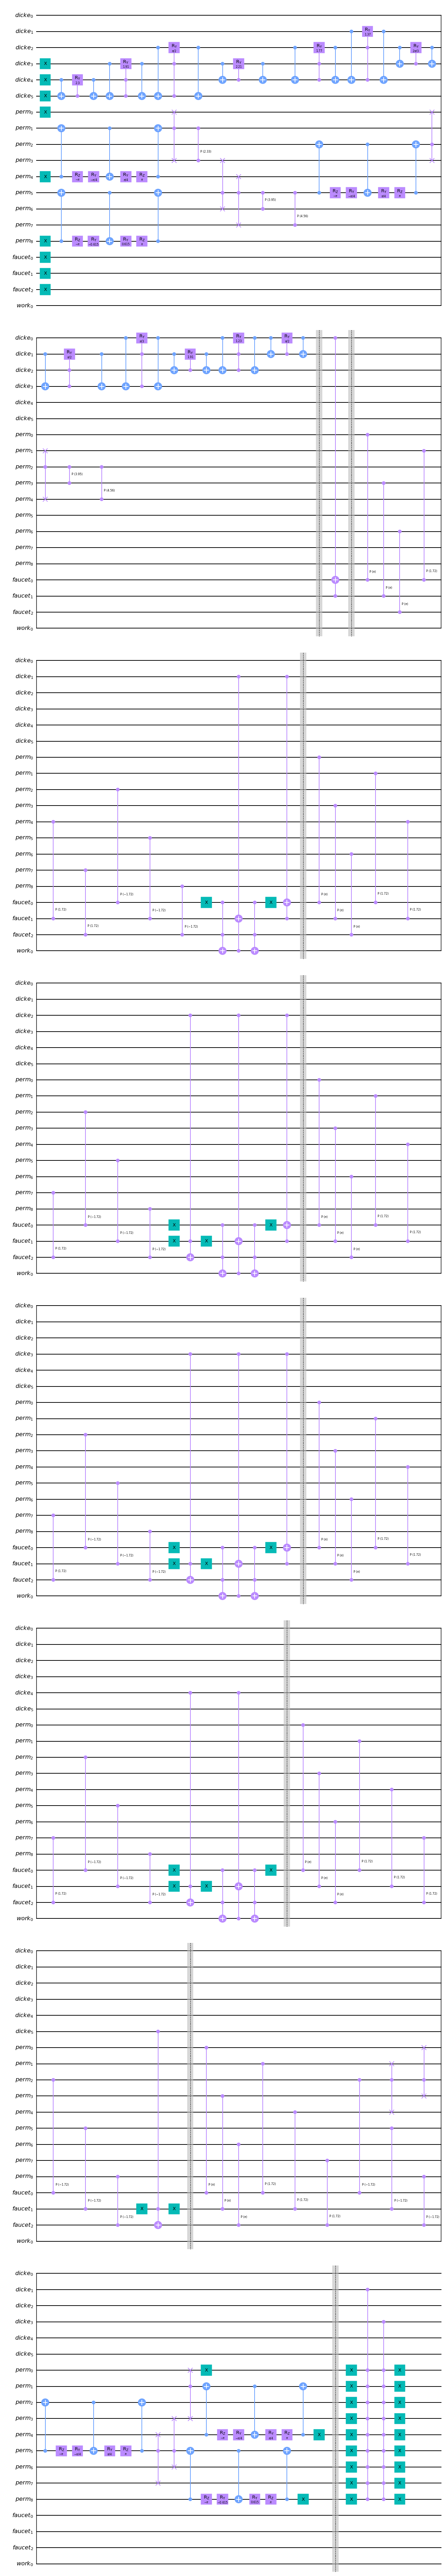

In [105]:
myBethe.draw('mpl')

In [96]:
check_state(myBethe, L, M)

KeyboardInterrupt: 

In [70]:
from qiskit.opflow import CircuitOp, CircuitStateFn

from qiskit.opflow import X, Y, Z, I

op = Z ^ 0 *I ^ 0*Z ^ 0*I ^ 0*I ^ 0*I

psi = CircuitStateFn(myBethe)

In [71]:
from qiskit import Aer
from qiskit.opflow import AerPauliExpectation, CircuitSampler, StateFn

# define your backend or quantum instance (where you can add settings)
backend = Aer.get_backend('qasm_simulator') 

# define the state to sample
measurable_expression = StateFn(op, is_measurement=True).compose(psi) 

expectation = AerPauliExpectation().convert(measurable_expression)
sampler = CircuitSampler(backend).convert(expectation)  
print('Snapshot:', sampler.eval().real) 

# # convert to expectation value
# expectation = PauliExpectation().convert(measurable_expression)  

# # get state sampler (you can also pass the backend directly)
# sampler = CircuitSampler(q_instance).convert(expectation) 

# # evaluate
# print('Sampled:', sampler.eval().real)  

Snapshot: 0.0
